# Census Data Exploration  
## Retima Dangol - Dataiku Practical

In [8]:
# IMPORT STATEMENTS
import re
from collections import defaultdict

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import helpers           # contains function separetly to keep notebook clean

In [9]:
# ADDITIONAL NOTEBOOK SETUP
helpers.css_styling()    # Add styling for markdown cells for readability

In [10]:
# CONSTANT DECLARATIONS
TRAIN_FILE_PATH = "census_income_learn.csv"
TEST_FILE_PATH = "census_income_test.csv"
METADATA_FILE_PATH = "census_income_metadata.txt"

In [11]:
# Bring in train and test data
train_df = pd.read_csv(TRAIN_FILE_PATH, header=None)
test_df = pd.read_csv(TEST_FILE_PATH, header=None)

In [12]:
print("Train File has {:,} rows and {:,} columns".format(*train_df.shape))
print("Test File has {:,} rows and {:,} columns".format(*test_df.shape))

Train File has 199,523 rows and 42 columns
Test File has 99,762 rows and 42 columns


In [13]:
train_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.


<div class=discuss>
The dataframe does not have a header row, which although not stricitly necessary, makes it easier to discuss the model that is created and makes it easier to engineer novel features. The metadata file is a bit odd with the code mapping section having some mispellings and missing some columns so that was ignored, the distinct count metatdata section doesnt exactly specify the order of the columns since it forgets about the instance feature. The instance feature is discussed in the final section but this section again is missing some columns. So a bit of a manual approach is needed even with trying to parse the column names from the metadata file.

In [14]:
# Parse column info out of metadata file
col_info = {}
re_info_line = r'\| +([0-9]+) distinct values for attribute #([0-9]+) \(([a-zA-Z\-0-9\' ]+)\) ([a-z]+)'

with open(METADATA_FILE_PATH, 'r') as lines:
    for line_num, line in enumerate(lines):
        if  (line_num > 80) & (line_num < 121):
            distinct_count, col_num, col_descr, kind = re.match(re_info_line, line).groups()
            col_info[col_descr] = {'distinct_count': int(distinct_count),
                                   'col_num': int(col_num),
                                   'kind': kind}

In [15]:
# Generate a simple list of column name, manual add in instance weight and target
col_names = sorted([key for key in col_info], key=lambda x: col_info[x]['col_num'])
col_names.insert(24, 'instance weight')
col_names.append('target')

In [16]:
# Check that the columns names in the proper spot
for col_name, col_ind in zip(col_names, train_df.columns):
    if col_name in col_info:
        unique_count = train_df[col_ind].unique().__len__()
        should_be_count = col_info[col_name]['distinct_count']
        if unique_count != should_be_count:
            print(f'{col_name}:{should_be_count} and {col_ind}:{unique_count} do not match')
    else:
        print(f"No info {col_name}")

No info instance weight
No info target


<div class=discuss>
The above just checks the metadata claims distinct count with the actual to make sure this was assigned properly. No information on instance wieght and target were in this section so those have no comparison
</div>

In [17]:
# Assign columns names to dataframes 
train_df.columns = test_df.columns = col_names

## Feature Exploration

In [18]:
for col_name, info in col_info.items():
    if info['kind'] == 'nominal':
        train_df[col_name] = train_df[col_name].astype(str)
        test_df[col_name] = test_df[col_name].astype(str)

In [19]:
corr_vals, cat_columns = helpers.cat_correlation_heatmap(train_df)

<AxesSubplot:>

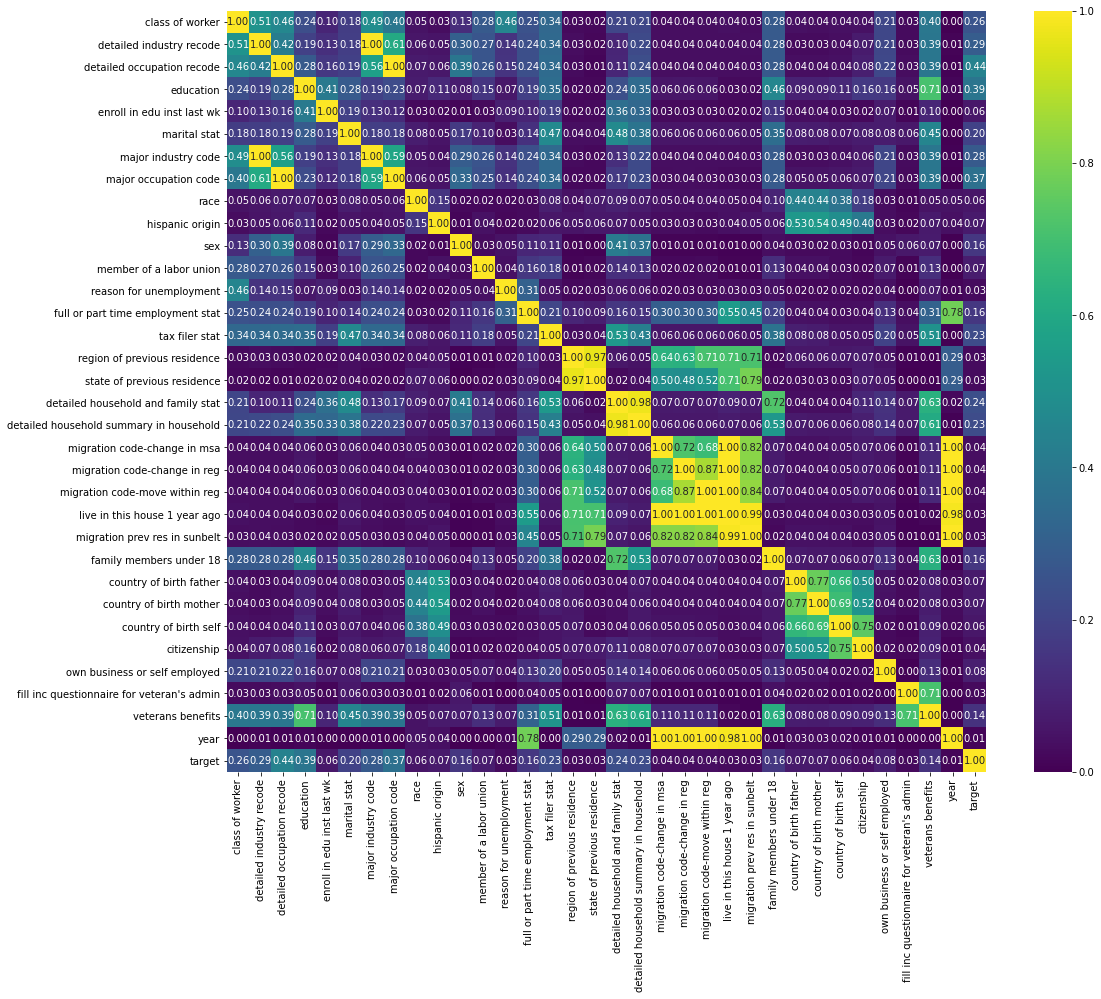

In [20]:
fig, ax = plt.subplots(figsize=(17, 14))
sns.heatmap(corr_vals, xticklabels=cat_columns, yticklabels=cat_columns, annot=True, fmt='.2f', cmap='viridis')

## Quick EDA 

In [116]:
cat_data = train_df[cat_columns]
cat_data_1 = cat_data[cat_data['target']== ' 50000+.']
cat_data_1.describe(include=["O"])

,class of worker,detailed industry recode,detailed occupation recode,education,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,year,target,education_mapped
count,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,...,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382
unique,9,51,47,16,3,7,24,15,5,10,...,42,42,42,5,3,3,2,2,1,10
top,Private,45,2,Bachelors degree(BA AB BS),Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Executive admin and managerial,White,All other,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,95,50000+.,bachelor
freq,7322,1044,2821,3915,12352,9600,1494,3593,11272,11767,...,10302,10388,11149,11149,10452,12151,12151,6543,12382,3915


In [121]:
cat_data_0 = cat_data[cat_data['target']== ' - 50000.']
cat_data_0.describe(include=["O"])

,class of worker,detailed industry recode,detailed occupation recode,education,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,year,target,education_mapped
count,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,...,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141
unique,9,52,47,17,3,7,24,15,5,10,...,43,43,43,5,3,3,3,2,1,11
top,Not in universe,0,0,Children,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,94,- 50000.,unknown
freq,99341,99778,99778,47422,174591,85368,99778,99778,156093,160140,...,148861,150091,165840,165843,170220,185388,137979,93988,187141,47422


<div class=discuss>
The highest correlated feature with the target is education, which makes intuitive sense
</div>

In [25]:
d = {' - 50000.': 0,  ' 50000+.': 1}

train_df['target_numerical'] = train_df['target'].map(d).fillna(train_df['target'])


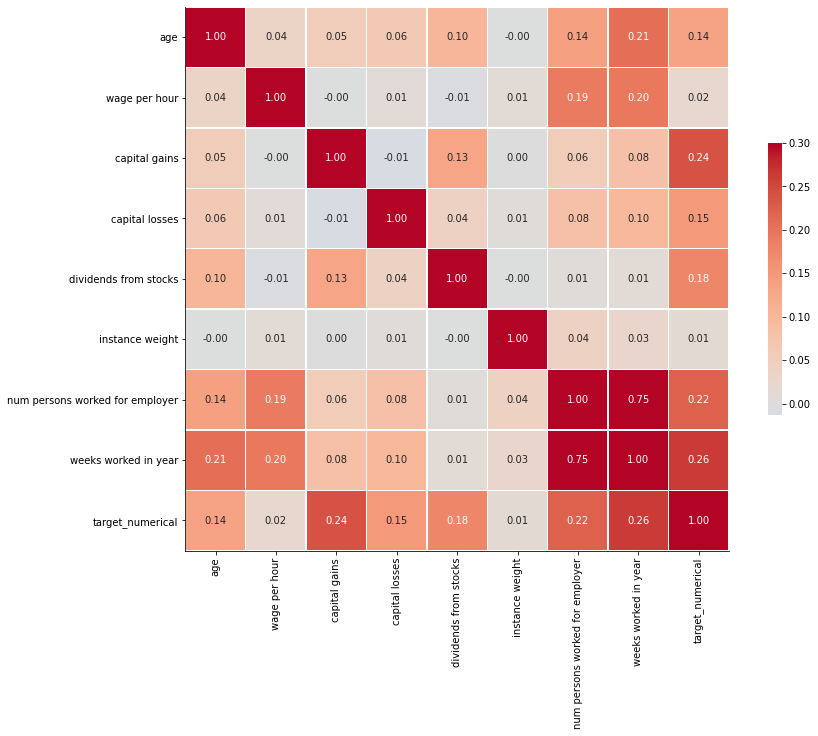

In [26]:
corr = train_df.corr()
g = sns.heatmap(corr,  vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(14,10)

## Transformation

In [103]:
education_mapping = {' Doctorate degree(PhD EdD)':'PHD',
 ' Prof school degree (MD DDS DVM LLB JD)':'Professional',
 ' Masters degree(MA MS MEng MEd MSW MBA)': 'masters',
 ' Bachelors degree(BA AB BS)':'bachelor',
 ' Associates degree-academic program':'community_college',
 ' Associates degree-occup /vocational':'skilled',
 ' Some college but no degree':'community_college',
 ' High school graduate':'HS_grad' ,
 ' 12th grade no diploma':'dropout', 
 ' 11th grade':'dropout',
 ' 10th grade':'dropout', 
 ' 9th grade':'dropout',
 ' 7th and 8th grade':'elementary',
 ' 5th or 6th grade':'elementary',
 ' 1st 2nd 3rd or 4th grade':'primary',
 ' Less than 1st grade':'primary',
 ' Children':'unknown'}

In [33]:
train_df['education'].unique()

array([' High school graduate', ' Some college but no degree',
       ' 10th grade', ' Children', ' Bachelors degree(BA AB BS)',
       ' Masters degree(MA MS MEng MEd MSW MBA)', ' Less than 1st grade',
       ' Associates degree-academic program', ' 7th and 8th grade',
       ' 12th grade no diploma', ' Associates degree-occup /vocational',
       ' Prof school degree (MD DDS DVM LLB JD)', ' 5th or 6th grade',
       ' 11th grade', ' Doctorate degree(PhD EdD)', ' 9th grade',
       ' 1st 2nd 3rd or 4th grade'], dtype=object)

In [87]:
train_df['education_mapped']= train_df['education'].map(education_mapping).fillna(train_df['education'])

In [82]:
len(train_df['education_mapped'].unique())

11

In [83]:
len(train_df['education'].unique())

17

<AxesSubplot:>

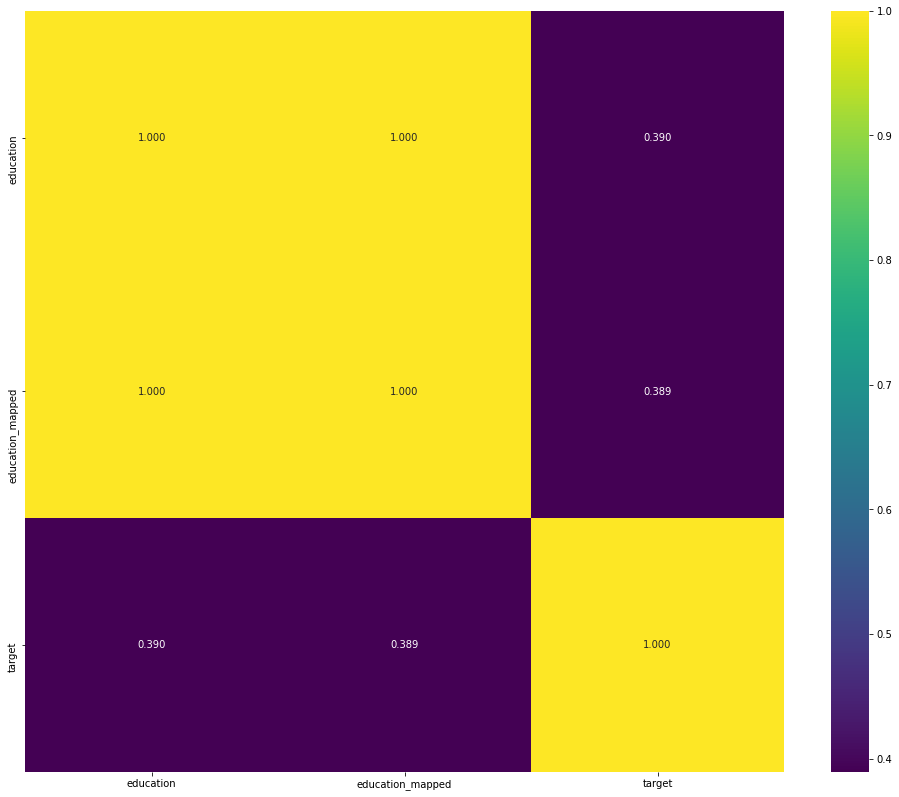

In [84]:
small_cols = ['education','education_mapped','target']

corr_vals, small_cols = helpers.cat_correlation_heatmap(train_df[small_cols])
fig, ax = plt.subplots(figsize=(17, 14))
sns.heatmap(corr_vals, xticklabels=small_cols, 
            yticklabels=small_cols, 
            annot=True,
            fmt='.3f', 
            cmap='viridis')

In [58]:
train_df['education'].unique()

array([' High school graduate', ' Some college but no degree',
       ' 10th grade', ' Children', ' Bachelors degree(BA AB BS)',
       ' Masters degree(MA MS MEng MEd MSW MBA)', ' Less than 1st grade',
       ' Associates degree-academic program', ' 7th and 8th grade',
       ' 12th grade no diploma', ' Associates degree-occup /vocational',
       ' Prof school degree (MD DDS DVM LLB JD)', ' 5th or 6th grade',
       ' 11th grade', ' Doctorate degree(PhD EdD)', ' 9th grade',
       ' 1st 2nd 3rd or 4th grade'], dtype=object)

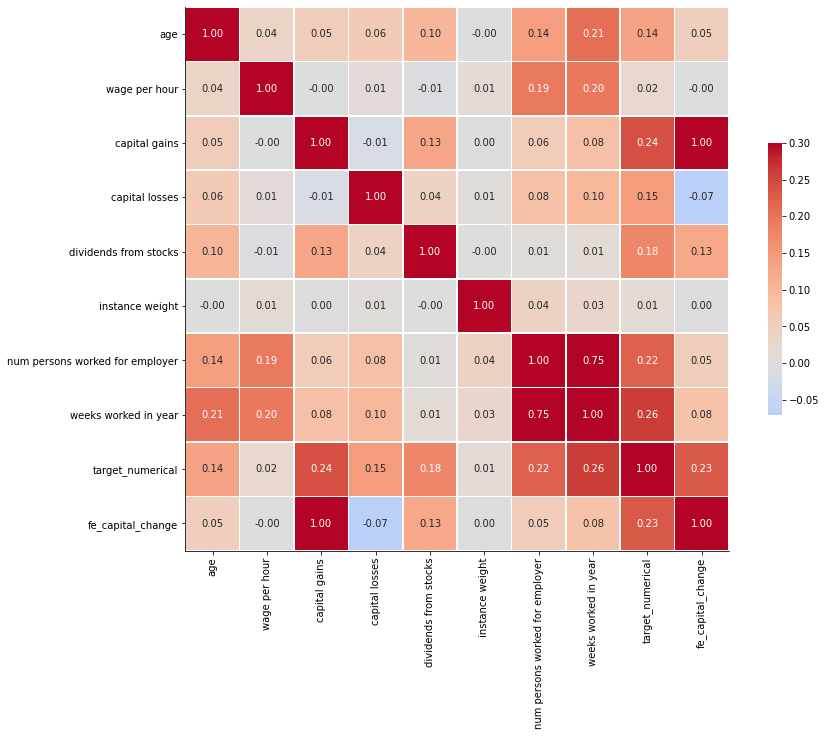

In [122]:
train_df['fe_capital_change'] = train_df['capital gains']- train_df['capital losses']

corr = train_df.corr()
g = sns.heatmap(corr,  vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(14,10)

## Models:

In [123]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,15 hours 5 mins
H2O_cluster_timezone:,America/Denver
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,1 month and 20 days
H2O_cluster_name:,H2O_from_python_rdangol_2y87lm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.285 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [125]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [126]:
hdf_train= h2o.H2OFrame(train_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [148]:
num_columns= train_df.select_dtypes(include=['number']).columns

In [170]:
response = 'target'
predictors = [x for x in train_df.columns if (x!=response) and (x!='target_numerical') ]

hdf_train[response] = hdf_train[response].asfactor()

for x in cat_columns:
    hdf_train[x] = hdf_train[x].asfactor()
for x in num_columns:
    hdf_train[x] = hdf_train[x].asnumeric()
    
train, valid = hdf_train.split_frame([.8])

## GBM

In [173]:
gbm_model = H2OGradientBoostingEstimator()

gbm_model.train(x = predictors,
                y = response,
                training_frame  = train,
                validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [205]:
gbm_model.F1(train= True, valid= True)

{'train': [[0.29745627285857174, 0.6417090744193078]],
 'valid': [[0.2931181163749244, 0.6045197740112994]]}

## XGBoost

In [189]:
from h2o.estimators import H2OXGBoostEstimator

xgb_model = H2OXGBoostEstimator()
xgb_model.train(x=predictors,
                  y=response,
                  training_frame=train,
                  validation_frame=valid)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [206]:
# Eval performance:
xgb_model.F1(train= True, valid= True)

{'train': [[0.2949996130032973, 0.6618485742379547]],
 'valid': [[0.3131138414144516, 0.618394513916902]]}

## SVM

In [ ]:
from h2o.estimators import H2OSupportVectorMachineEstimator


# Build and train the model:
svm_model = H2OSupportVectorMachineEstimator()
svm_model.train(y = response, 
                training_frame = train,
                validation_frame=valid)

# Eval performance:
perf = svm_model.model_performance()

# Generate predictions (if necessary):
pred = svm_model.predict(valid)

## GLM

In [217]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator


glm_model = H2OGeneralizedLinearEstimator()

glm_model.train(predictors, 
                response, 
                training_frame= train,
                validation_frame=valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [218]:
glm_model.F1(train= True, valid= True)

{'train': [[0.2629350300702998, 0.58192623337421]],
 'valid': [[0.258591791915505, 0.5649591685226428]]}

## Random Forest 

In [222]:
from h2o.estimators import H2ORandomForestEstimator

# Build and train the model:
drf_model = H2ORandomForestEstimator()

drf_model.train(x=predictors,
               y=response,
               training_frame=train,
               validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [223]:
drf_model = cars_drf